## Generative Adversarial Network (GAN) with Python and Tensorflow

### Import dependencies

In [ ]:
# dataset and visualization components
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# modeling components
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

# losses and optimizers components
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

# subclassed model components
import tensorflow as tf
from keras.models import Model

# callback components
import os
from keras.utils import array_to_img
from keras.callbacks import Callback

### Load and visualize data

In [ ]:
# Load the mnist dataset from tensorflow_datasets
ds = tfds.load('mnist', split='train')

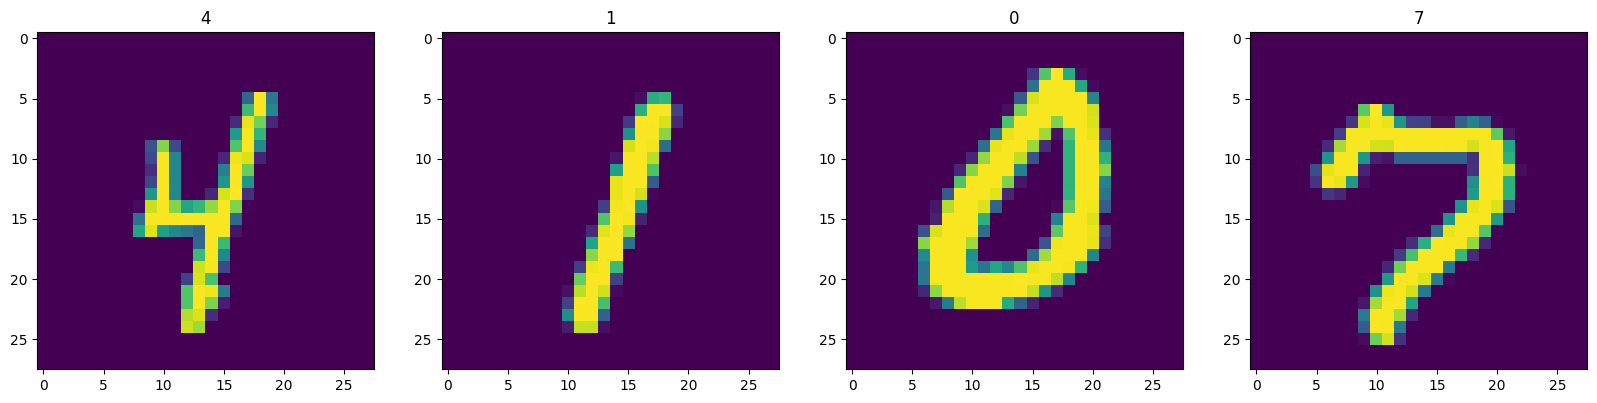

In [ ]:
# Convert the data to a numpy iterator
data_iterator = ds.as_numpy_iterator()

# Visualize the data
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    # Grab an image and label
    sample = data_iterator.next()
    ax[idx].imshow(np.squeeze(sample['image']))
    ax[idx].title.set_text(sample['label'])

### Pre-process data

In [ ]:
# Scale all the images
def scale_images(data): 
    image = data['image']
    return image / 255

In [ ]:
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)

In [ ]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

### Build the generator

In [ ]:
def build_generator():
    model = Sequential()                       # define our model
    model.add(Dense(7*7*128, input_dim=128))   # add Dense layer with random noise as input
    model.add(LeakyReLU(0.2))                  # apply LeakyRelu activation
    model.add(Reshape((7,7,128)))              # reshape to 17*17*128

    # Upsampling block - 1
    model.add(UpSampling2D())                  # layer used to increase the spatial resolution of the input
    model.add(Conv2D(128, 5, padding='same'))  # convolutional nn layer with 128 units, kernel size 5x5 and padding same
    model.add(LeakyReLU(0.2))                  # apply LeakyRelu activation

    # Upsampling block - 2
    model.add(UpSampling2D())                  # layer used to increase the spatial resolution of the input
    model.add(Conv2D(128, 5, padding='same'))  # convolutional nn layer with 128 units, kernel size 5x5 and padding same
    model.add(LeakyReLU(0.2))                  # apply LeakyRelu activation

    # Downsampling block - 1
    model.add(Conv2D(128, 4, padding='same'))  # convolutional nn layer with 128 units, kernel size 4x4 and padding same
    model.add(LeakyReLU(0.2))                  # apply LeakyRelu activation

    # Downsampling block - 2
    model.add(Conv2D(128, 4, padding='same'))  # convolutional nn layer with 128 units, kernel size 4x4 and padding same
    model.add(LeakyReLU(0.2))                  # apply LeakyRelu activation

    # convolutional nn layer to change to 1 channel,kernel size 4x4, same padding and a sigmoid activation this time
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    # return the model
    return model

In [ ]:
# generator summary
generator = build_generator()
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_4 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

### Test the generator

1/1 [==============================] - 0s 194ms/step


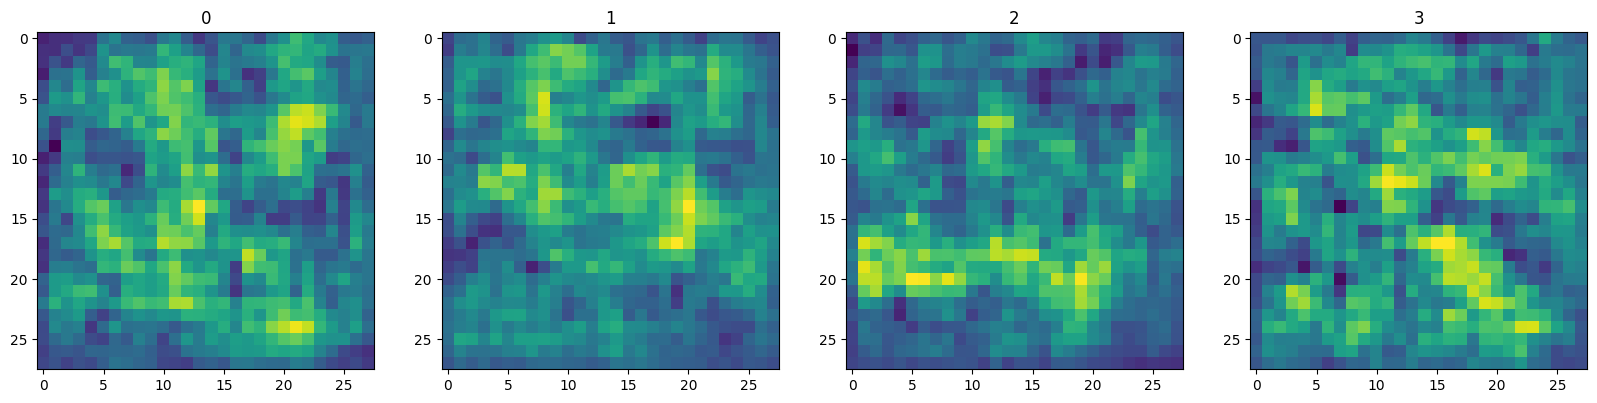

In [ ]:
# Generate 4 new images
img = generator.predict(np.random.randn(4,128,1))

# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop 4 times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

### Build the discriminator

In [ ]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [ ]:
# discriminator summary
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_10 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_11 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 128)      

### Test the discriminator

In [ ]:
# generate 4 images
img = generator.predict(np.random.randn(4,128,1))
# use the discriminator to predict the images made by the generator
discriminator.predict(img)

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 83ms/step


array([[0.49269447],
       [0.4925592 ],
       [0.49265987],
       [0.49283397]], dtype=float32)

### Build training loop

In [ ]:
# setup losses and optimizers
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [ ]:
# build subclassed model
class numbersGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [ ]:
# Create instance of subclassed model
numgan = numbersGAN(generator, discriminator)
# Compile the model
numgan.compile(g_opt, d_opt, g_loss, d_loss)

### Build callback

In [ ]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

### Train the model

In [ ]:
# Recommend 1500-2000 epochs
hist = numgan.fit(ds, epochs=100, callbacks=[ModelMonitor()])

Epoch 1/10
  6/469 [..............................] - ETA: 1:24 - d_loss: 0.6936 - g_loss: 0.6882

469/469 [==============================] - 88s 184ms/step - d_loss: 0.4284 - g_loss: 1.2674
Epoch 2/10
469/469 [==============================] - 86s 183ms/step - d_loss: 0.3309 - g_loss: 2.3290
Epoch 3/10
469/469 [==============================] - 86s 184ms/step - d_loss: 0.6811 - g_loss: 0.7885
Epoch 4/10
469/469 [==============================] - 86s 182ms/step - d_loss: 0.6975 - g_loss: 0.6512
Epoch 5/10
469/469 [==============================] - 86s 183ms/step - d_loss: 0.6976 - g_loss: 0.6398
Epoch 6/10
469/469 [==============================] - 86s 184ms/step - d_loss: 0.6970 - g_loss: 0.6795
Epoch 7/10
469/469 [==============================] - 87s 184ms/step - d_loss: 0.6964 - g_loss: 0.6882
Epoch 8/10
469/469 [==============================] - 86s 183ms/step - d_loss: 0.6910 - g_loss: 0.7125
Epoch 9/10
469/469 [==============================] - 86s 184ms/step - d_loss: 0.6959 - g_loss: 0.6848
Epoch 10/10
469/469 [==============================] - 86s 183ms/step - d_loss: 0.69

### Revew model performance

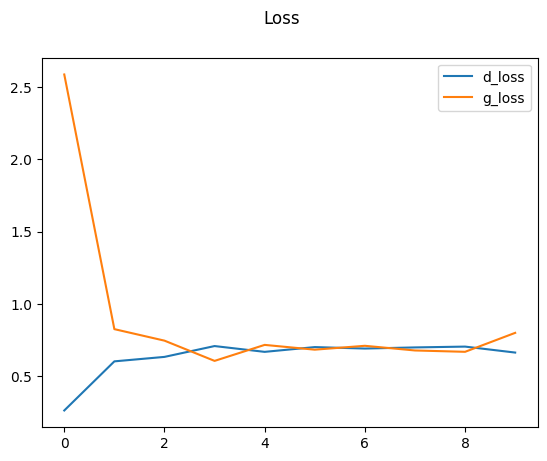

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

### Test the trained generator

1/1 [==============================] - 0s 226ms/step


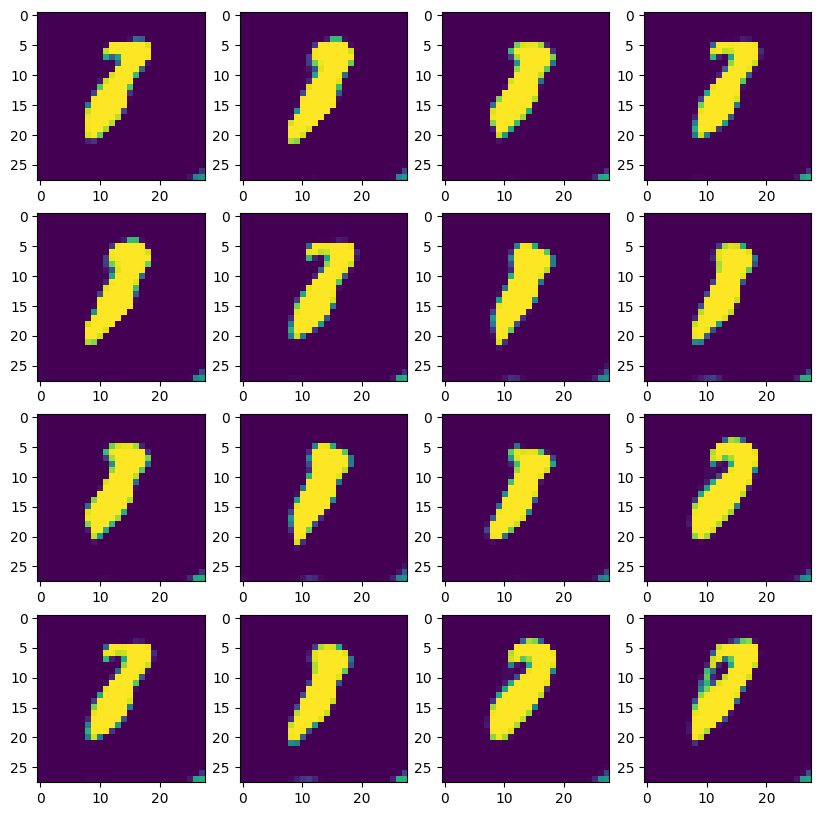

In [ ]:
# generate new images
imgs = generator.predict(tf.random.normal((16, 128, 1)))
# plot the generated images
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

### Save the model

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')

In [ ]:
!zip -r /content/images.zip /content/images